# Install Packages

In [ ]:
!pip install ultralytics
!pip install torch torchvision torchaudio
!pip install matplotlib.pyplot
!pip install Pillow

# Define Specs

In [2]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("All Physical Devices:", physical_devices)
print("GPUs:", physical_devices)

print("CUDA version:", tf.sysconfig.get_build_info()["cuda_version"])
print("cuDNN version:", tf.sysconfig.get_build_info()["cudnn_version"])



TensorFlow version: 2.16.1
All Physical Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CUDA version: 12.0
cuDNN version: 8


# Import

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from PIL import Image
import numpy as np
import random
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from efficientnet_pytorch import EfficientNet

# Define Custom Dataset

In [3]:
# Define the dataset path
data_dir = '/home/iambrink/Shark_Object_Detection/Shark_Classification_Data_V2'

# Custom Dataset class for loading images
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Traverse through each class folder
        for label, class_name in enumerate(os.listdir(root)):
            class_folder = os.path.join(root, class_name)
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                self.images.append(img_path)
                self.labels.append(label)  # Use class index as label

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')  # Load image and convert to RGB
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, label

# Define Transformers

In [4]:
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(320),  # Resize to 224x224 to match EfficientNet-B0 input size
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomVerticalFlip(),    # Randomly flip images vertically 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color adjustments
    transforms.RandomRotation(15),      # Random rotation
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),  # Apply Gaussian blur 
    transforms.ToTensor(),              # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Define test/validation transformations (without augmentations)
data_transforms_test = transforms.Compose([
    transforms.Resize(320),             # Resize to 224x224
    transforms.CenterCrop(320),         # Center crop
    transforms.ToTensor(),              # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Set-up Data

In [5]:
# Define batch size
batch_size = 64

# Load datasets using the custom dataset class
train_dataset = CustomDataset(root=os.path.join(data_dir, 'train'), transform=data_transforms)
valid_dataset = CustomDataset(root=os.path.join(data_dir, 'valid'), transform=data_transforms)
test_dataset = CustomDataset(root=os.path.join(data_dir, 'test'), transform=data_transforms_test)

# Create DataLoaders for each dataset
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Get dataset sizes and class names
dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(valid_dataset),
    'test': len(test_dataset)
}
class_names = os.listdir(os.path.join(data_dir, 'train'))  # Get class names from training data

# Print dataset sizes and class names for verification
print(f"Dataset Sizes: {dataset_sizes}")
print(f"Class Names: {class_names}")

Dataset Sizes: {'train': 2116, 'valid': 450, 'test': 450}
Class Names: ['Blue Shark', 'Whale Shark', 'Nurse Shark', 'Tiger Shark', 'Whitetip Shark', 'Sand Tiger Shark', 'Bull Shark', 'Hammerhead Shark', 'White Shark', 'Mako Shark']


# Define Model, Device, Criterion, Optmizer, and Scheduler

In [7]:
# Load EfficientNetB0 model pre-trained on ImageNet
model = models.efficientnet_b0(weights='DEFAULT')  # Update this for newer torchvision versions

# Modify the classifier layer to match your 10 shark species
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 10)  # 10 shark species

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Define loss function (cross-entropy for classification)
criterion = nn.CrossEntropyLoss()

# Optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=.001)
# scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=3, verbose=True)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500)  


# Define Seed

In [8]:
def set_seed(seed_value=42):
    # Set seed for Python's random module
    random.seed(seed_value)

    # Set seed for NumPy's random number generator
    np.random.seed(seed_value)

    # Set seed for PyTorch (both CPU and GPU, if applicable)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)


In [40]:
# save_path = '/home/iambrink/Shark_Object_Detection/Shark_AI_Detection_Model_V2'
best_model_path = '/home/iambrink/Shark_Object_Detection/Shark_Classification_Model_V3'
save_path = '/home/iambrink/Shark_Object_Detection/Best_Shark_Detection_Model.pth'

# Pre load Model 

In [27]:
if os.path.exists(best_model_path):
    model = models.efficientnet_b0(weights='DEFAULT')  # Initialize the same architecture
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 10)  # Assuming 10 classes (shark species)
    model.load_state_dict(torch.load(best_model_path))  # Load the pre-saved model's state
    print("Loaded super model from disk.")
    
    # Move model to device (GPU/CPU)
    model = model.to(device)

    # Evaluate on the test set
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    # Calculate evaluation metrics
    SMaccuracy = accuracy_score(y_true, y_pred)
    SMprecision, SMrecall, SMf1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    SMauc = roc_auc_score(y_true, y_prob, multi_class='ovr')

    # Print confusion matrix and classification report
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Print additional stats
    print(f"Super Model Accuracy: {100 * SMaccuracy:.2f}%")
    print(f"Super Model AUC: {SMauc:.4f}")
    print(f"Super Model Precision: {SMprecision:.4f}")
    print(f"Super Model Recall: {SMrecall:.4f}")
    print(f"Super Model F1 Score: {SMf1:.4f}")
    

else:
    # If no super model exists, start with a new model
    model = models.efficientnet_b0(weights='DEFAULT')
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 10)
    print("No existing super model found, starting fresh.")

    model = model.to(device)


Loaded super model from disk.
Confusion Matrix:
[[41  1  0  0  0  0  0  1  0  2]
 [ 0 45  0  0  0  0  0  0  0  0]
 [ 0  1 39  0  0  1  1  3  0  0]
 [ 2  1  0 33  0  1  5  1  0  2]
 [ 1  0  0  0 42  0  0  0  2  0]
 [ 0  0  0  1  0 42  1  0  1  0]
 [ 3  0  0  2  2  2 32  3  1  0]
 [ 1  0  1  0  0  0  4 38  0  1]
 [ 2  0  0  1  0  0  0  0 41  1]
 [ 2  0  0  0  0  0  0  1  4 38]]
Classification Report:
                  precision    recall  f1-score   support

      Blue Shark       0.79      0.91      0.85        45
     Whale Shark       0.94      1.00      0.97        45
     Nurse Shark       0.97      0.87      0.92        45
     Tiger Shark       0.89      0.73      0.80        45
  Whitetip Shark       0.95      0.93      0.94        45
Sand Tiger Shark       0.91      0.93      0.92        45
      Bull Shark       0.74      0.71      0.73        45
Hammerhead Shark       0.81      0.84      0.83        45
     White Shark       0.84      0.91      0.87        45
      Mako Shark 

# ReduceLROnPlateau Trial

In [12]:
# # Training and Validation Loop
# num_epochs = 500
# best_val_acc = 0.0

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0.0
#     train_acc = 0.0
#     for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output, target)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
#         train_acc += accuracy_score(target.cpu(), output.argmax(dim=1).cpu())
#     train_loss /= len(trainloader)
#     train_acc /= len(trainloader)

#     model.eval()
#     val_loss = 0.0
#     val_acc = 0.0
#     with torch.no_grad():
#         for batch_idx, (data, target) in enumerate(tqdm(validloader)):
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             loss = criterion(output, target)
#             val_loss += loss.item()
#             val_acc += accuracy_score(target.cpu(), output.argmax(dim=1).cpu())
#     val_loss /= len(validloader)
    
#     val_acc /= len(validloader)

#     # Update ReduceLROnPlateau scheduler based on validation loss
#     scheduler.step(val_loss)

#     print(f'Epoch: {epoch+1}/{num_epochs} \tTrain Loss: {train_loss:.4f} \tTrain Acc: {train_acc:.4f} \tVal Loss: {val_loss:.4f} \tVal Acc: {val_acc:.4f}')

#     # Save the model if the validation accuracy improves
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         torch.save(model.state_dict(), save_path)
#         print(f'Best model saved with Val Acc: {best_val_acc:.4f}')


# CosineAnnealingLR Trial

In [ ]:
# Training and Validation Loop
num_epochs = 500
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Accumulate training loss and accuracy
        train_loss += loss.item()
        train_acc += accuracy_score(target.cpu(), output.argmax(dim=1).cpu())
    
    train_loss /= len(trainloader)
    train_acc /= len(trainloader)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(validloader)):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            # Accumulate validation loss and accuracy
            val_loss += loss.item()
            val_acc += accuracy_score(target.cpu(), output.argmax(dim=1).cpu())
    
    val_loss /= len(validloader)
    val_acc /= len(validloader)

    # Update learning rate scheduler
    # For CosineAnnealingLR or StepLR
    if not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step()  # No need for epoch parameter

    # For ReduceLROnPlateau
    else:
        scheduler.step(val_loss)  # Use validation loss for ReduceLROnPlateau

    # Print progress for the current epoch
    print(f'Epoch: {epoch+1}/{num_epochs} \tTrain Loss: {train_loss:.4f} \tTrain Acc: {train_acc:.4f} \tVal Loss: {val_loss:.4f} \tVal Acc: {val_acc:.4f}')

    # Save the model if validation accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f'Best model saved with Val Acc: {best_val_acc:.4f}')


# Best Training Value Accuracy

In [12]:
best_val_acc

0.87890625

# Evaluate Model

In [ ]:
# Initialize empty lists to store true labels, predicted labels, and probabilities
y_true_Train = []
y_pred_Train = []
y_prob_Train = []

# Iterate over the test set
for inputs, labels in testloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Make predictions without computing gradients
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)

    # Append true labels, predicted labels, and probabilities
    y_true_Train.extend(labels.cpu().numpy())
    y_pred_Train.extend(preds.cpu().numpy())
    y_prob_Train.extend(probs.cpu().numpy())

# Convert lists to numpy arrays
y_true_Train = np.array(y_true_Train)
y_pred_Train = np.array(y_pred_Train)
y_prob_Train = np.array(y_prob_Train)

# Compute accuracy and misclassified examples
Taccuracy = accuracy_score(y_true_Train, y_pred_Train)
Tmissed = (y_true_Train != y_pred_Train).sum()

# Compute recall, precision, F1-score for each class
Tprecision = precision_score(y_true_Train, y_pred_Train, average='weighted')  # Weighted for class imbalance
Trecall = recall_score(y_true_Train, y_pred_Train, average='macro')
Tf1 = f1_score(y_true_Train, y_pred_Train, average='weighted')
Tauc = roc_auc_score(y_true_Train, y_prob_Train, multi_class='ovr', average='weighted')  
# Print classification report
print("Classification Report:")
print(classification_report(y_true_Train, y_pred_Train, target_names=class_names))

# Optionally, print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true_Train, y_pred_Train))

# Compute multi-class AUC score
# AUC requires probability scores rather than class labels
print(f'\nMisclassified examples: {Tmissed}')
print(f"Accuracy: {100 * Taccuracy:.2f}%")
print(f"          {y_true_Train.size - Tmissed}/{y_true_Train.size}")


print(f"\nAUC (Weighted, OvR): {Tauc}")
print(f"Precision (Weighted): {Tprecision:.4f}")
print(f"Recall (Weighted): {Trecall:.4f}")
print(f"F1-Score (Weighted): {Tf1:.4f}")


Save Best Model

In [ ]:
if SMaccuracy < Taccuracy:
    torch.save(model.state_dict(), best_model_path) 
    print(f'New model saved with Testing Accuracy: {Taccuracy:.4f}, replacing super model.')
else:
    print(f"Super model retained with Testing Accuracy: {SMaccuracy:.4f}")

Confusion Matrix

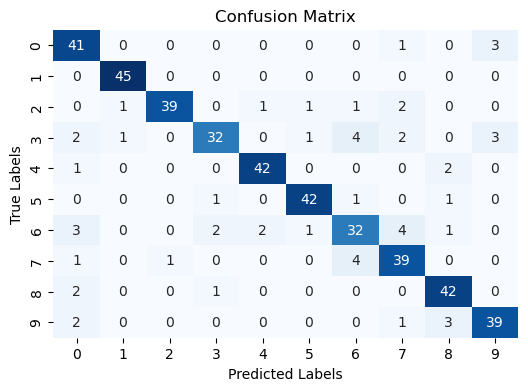

In [15]:
# Calculate confusion matrix
cm = confusion_matrix(y_true_Train, y_pred_Train)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

# Test Model

Load Model

In [ ]:
from efficientnet_pytorch import EfficientNet
import torch

# Load the state dict into the model, using strict=False to handle any mismatched keys
model = models.efficientnet_b0(weights='DEFAULT')  # Initialize the same architecture
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))  # Assuming 10 classes (shark species)
model.load_state_dict(torch.load('/home/iambrink/Shark_Object_Detection/Shark_AI_Detection_Model_V2'))  # Load the pre-saved model's state
# Set the model to evaluation mode
model.eval()

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Define Test

In [42]:
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# Calculate evaluation metrics
SMaccuracy = accuracy_score(y_true, y_pred)
SMprecision, SMrecall, SMf1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
SMauc = roc_auc_score(y_true, y_prob, multi_class='ovr')

# Print confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Print additional stats
print(f"Super Model Accuracy: {100 * SMaccuracy:.2f}%")
print(f"Super Model AUC: {SMauc:.4f}")
print(f"Super Model Precision: {SMprecision:.4f}")
print(f"Super Model Recall: {SMrecall:.4f}")
print(f"Super Model F1 Score: {SMf1:.4f}")

Confusion Matrix:
[[42  1  0  0  0  0  0  1  0  1]
 [ 0 44  1  0  0  0  0  0  0  0]
 [ 0  1 42  0  0  1  0  1  0  0]
 [ 4  2  0 33  0  1  4  1  0  0]
 [ 1  0  0  0 40  0  1  0  3  0]
 [ 0  0  0  1  0 42  1  0  1  0]
 [ 3  0  0  2  2  1 33  3  1  0]
 [ 1  0  1  0  0  0  4 38  0  1]
 [ 2  0  0  1  0  0  0  0 41  1]
 [ 2  0  0  0  0  0  0  1  4 38]]
Classification Report:
                  precision    recall  f1-score   support

      Blue Shark       0.76      0.93      0.84        45
     Whale Shark       0.92      0.98      0.95        45
     Nurse Shark       0.95      0.93      0.94        45
     Tiger Shark       0.89      0.73      0.80        45
  Whitetip Shark       0.95      0.89      0.92        45
Sand Tiger Shark       0.93      0.93      0.93        45
      Bull Shark       0.77      0.73      0.75        45
Hammerhead Shark       0.84      0.84      0.84        45
     White Shark       0.82      0.91      0.86        45
      Mako Shark       0.93      0.84      0.88

Confusion Matrix

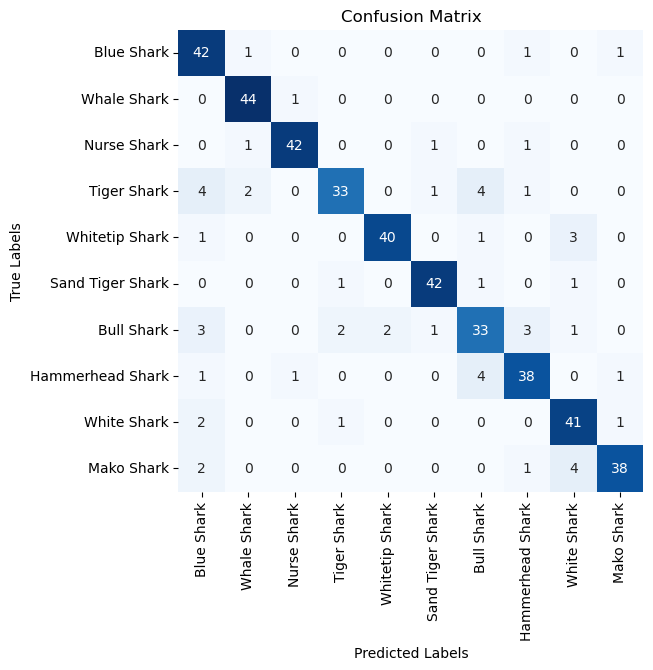

In [49]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show the plot
plt.show()
